### ICA with epochs in columns

Here the data is reshaped to have epochs in columns, such that each datapoint is the same sample from the same channel across epochs. E.g. the first datapoint is the first sample from the first channel for all epochs. It then concatenates the data vertically such that all control data is first, then tapping left and tapping right.

We then compute sliding windows on the ICs such that each datapoint passed to GMM is dim=num_ICs with each entry being the mean of the sliding window for that IC.

This was done as an attempt to get a general classification of whether there are any statistical differences between the concatenated sets.

This gives a clear classification from GMM of the concatenated data. However, this classification persists even if the data consists of 2 sets of concatenated control data. This is due to the fact that each set of control data consist of a specific combination of 10 specific control epochs only differentiated by the highly correlated channels. The ICA, therefore, notices the statistical difference between the two groups. There is no apparent fix for this, and this dataloader is, therefore, not suited for the task at hand

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


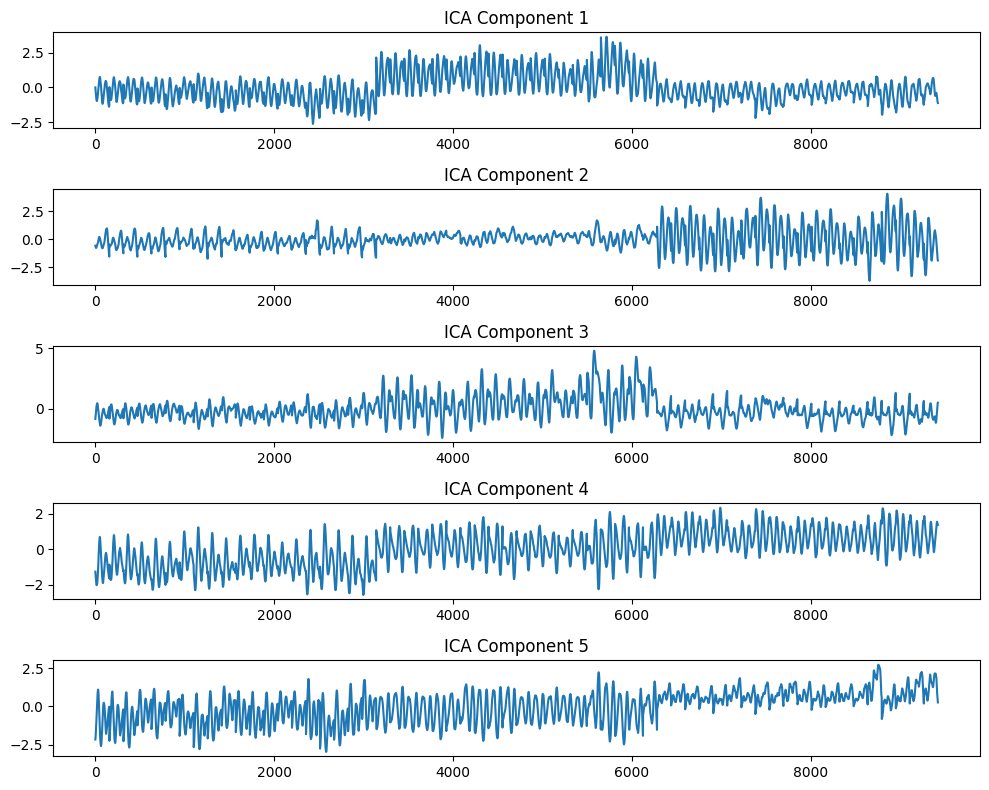

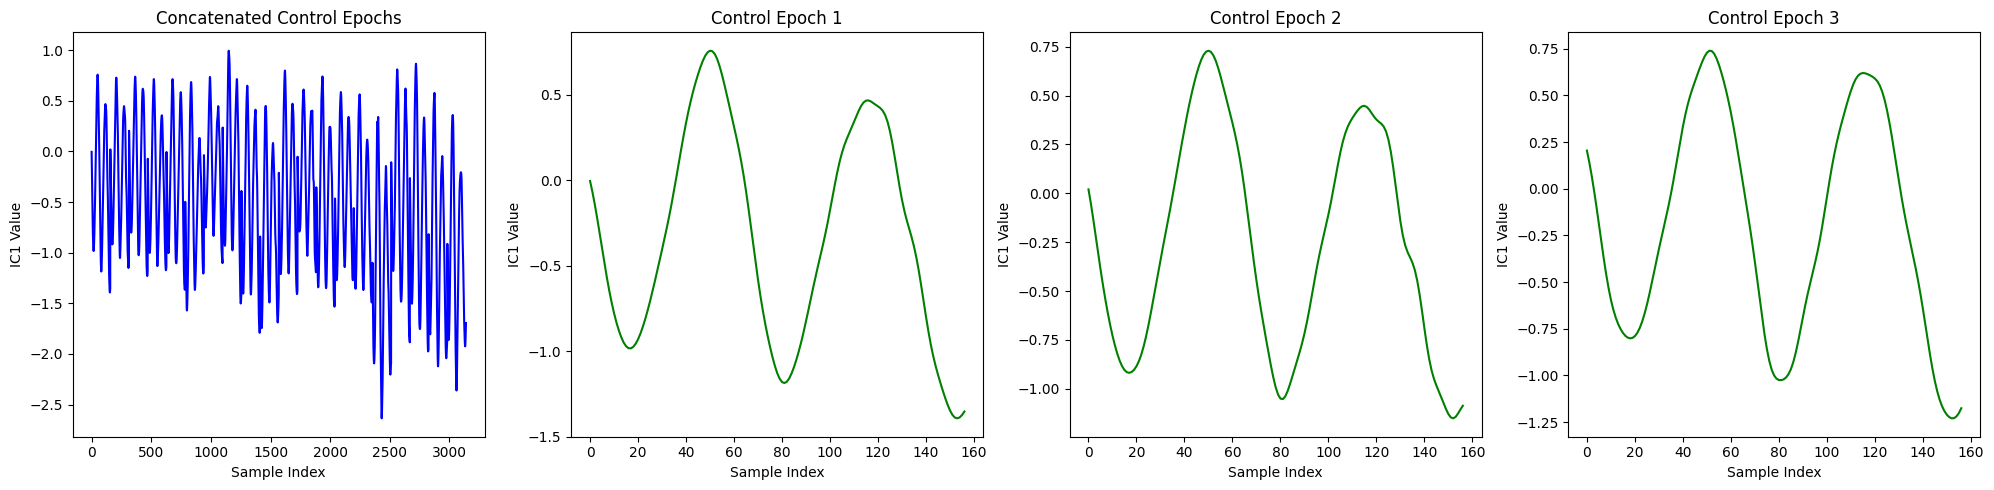

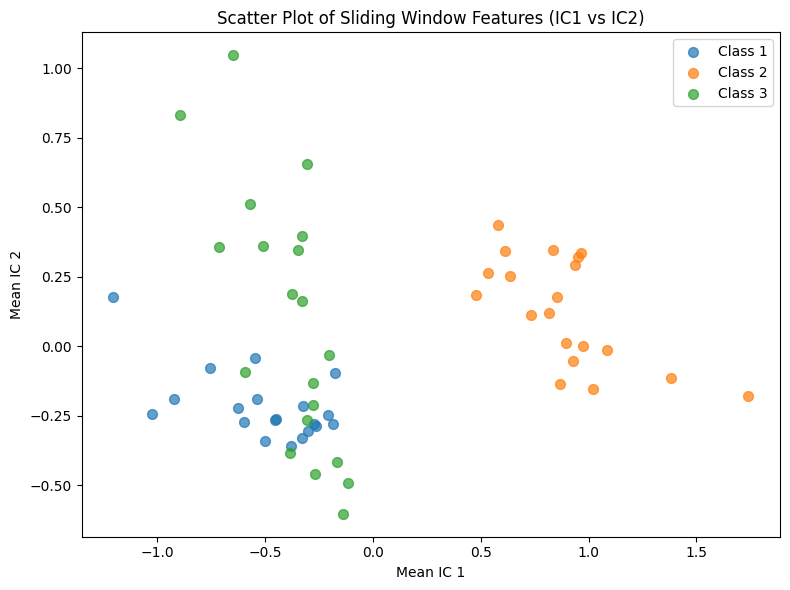

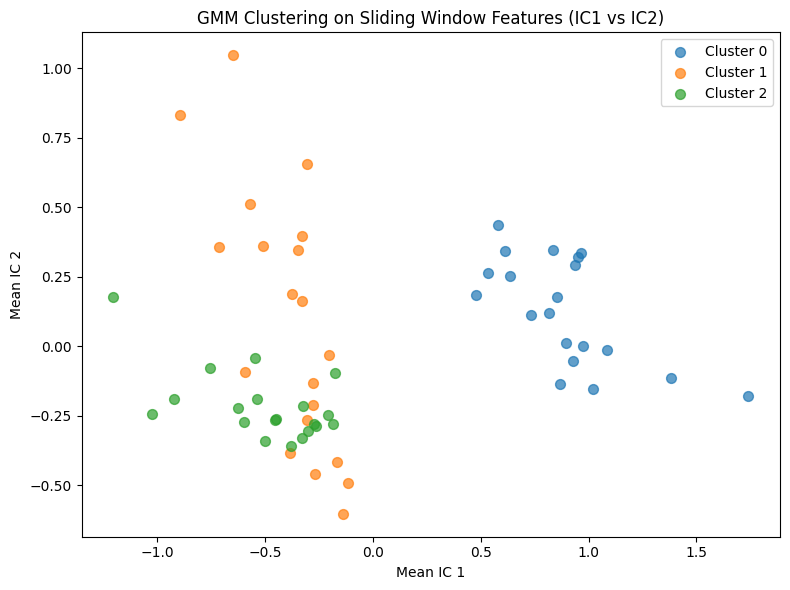

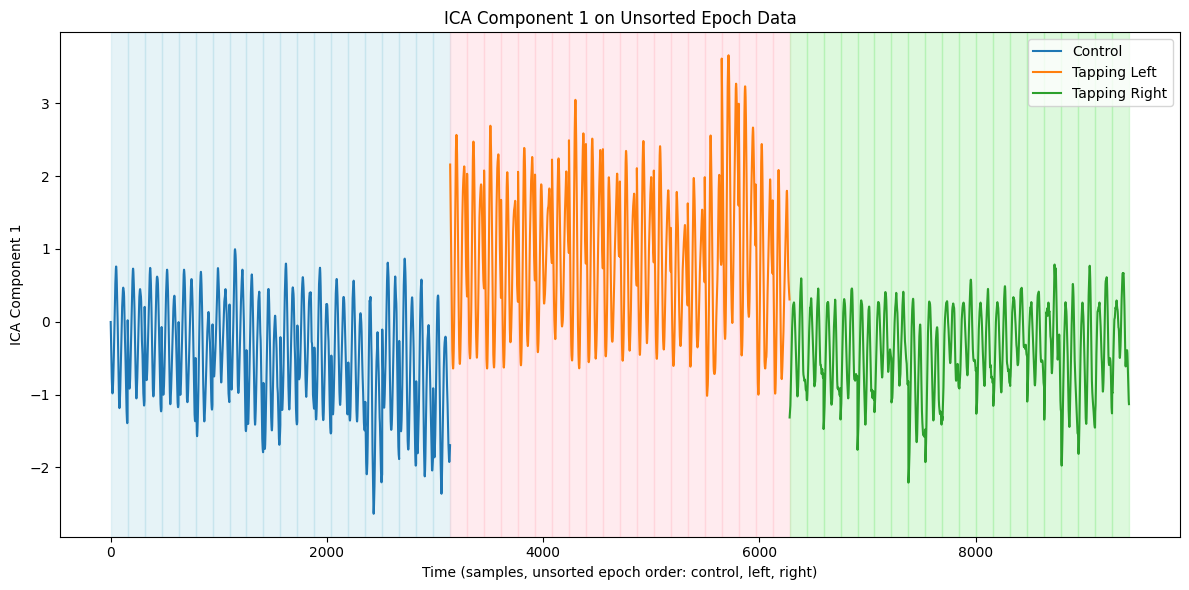

In [3]:
import os
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import sys
sys.path.insert(0, os.path.abspath('..'))
from Preprocessing.preprocessing_mne import get_raw_subject_data, get_raw_control_subject_data
from ICA_plotting import *
from sklearn.metrics import silhouette_score

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

def reshape_epochs_with_indices(epochs, n_epochs_to_include):
    """
    Reshape epochs data to a 2D array and create an index array that indicates the original epoch for each sample.
    Using the minimum number of samples from the conditions for uniformity for concatenation.

    Parameters:
        epochs: MNE epochs object containing the data.
        n_epochs_to_include: Number of epochs to include (using the minimum sample count for uniformity).

    Returns:
        tuple: (reshaped data, array of original epoch indices)
    """
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    epoch_data_reshaped = np.hstack([epoch_data[i].flatten(order='C')[:, None] for i in range(len(epoch_data))])
    orig_indices = np.repeat(epochs.selection[:n_epochs_to_include], n_epoch_size)
    return epoch_data_reshaped, orig_indices

def load_data(subject=3, control_only=True, n=20):
    """
    Load data from MNE, reshape epochs, and concatenate data from control, left, and right conditions.
    n determines how many epochs of each class will be used.
    In the control only case, n is the total number of epochs (combined from the two random splits).

    Parameters:
        subject: Subject ID to load data for.
        control_only: If True, only load the control data.
        n: Number of epochs to include for each condition.
    
    Returns:
        tuple: (X, orig_indices, y, control_data, left_data, right_data, num_samples)
            - X: concatenated continuous data.
            - orig_indices: epoch indices for each sample.
            - y: labels for each sample.
            - control_data, left_data, right_data: individual condition data (None for left/right in control_only).
            - num_samples: length of the first epoch sample (number of time points).
    """
    if not control_only:
        epochs = get_raw_subject_data(subject=subject, tmin=-5, tmax=15)
        control = epochs['Control']
        left = epochs['Tapping_Left']
        right = epochs['Tapping_Right']

        control.pick_types(fnirs='hbo')
        left.pick_types(fnirs='hbo')
        right.pick_types(fnirs='hbo')
        
        # Use n epochs for each condition.
        control_data, ctrl_idx = reshape_epochs_with_indices(control, n)
        left_data, left_idx = reshape_epochs_with_indices(left, n)
        right_data, right_idx = reshape_epochs_with_indices(right, n)
        
        # Concatenating data.
        X = np.concatenate([control_data, left_data, right_data], axis=0)
        orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
        y = np.concatenate([np.full(control_data.shape[0], 1),
                            np.full(left_data.shape[0], 2),
                            np.full(right_data.shape[0], 3)])
        # Get number of samples from the first epoch of the control condition.
        num_samples = control.get_data()[0].shape[1]
        return X, orig_indices, y, control_data, left_data, right_data, num_samples
    else:
        control = get_raw_control_subject_data(subject=subject)
        control.pick_types(fnirs='hbo')
        
        # Randomly select n epochs from control.
        all_idx = np.arange(control.selection.shape[0])
        np.random.shuffle(all_idx)
        selected_idx = all_idx[:n]
        
        # Split the selected indices into two roughly equal sets.
        split_point = len(selected_idx) // 2
        idx_set1 = selected_idx[:split_point]
        idx_set2 = selected_idx[split_point:]
        
        # Subset the epochs for each split.
        control_set1 = control[idx_set1]
        control_set2 = control[idx_set2]
        
        # Reshape each set independently.
        data1, idx1 = reshape_epochs_with_indices(control_set1, control_set1.selection.shape[0])
        data2, idx2 = reshape_epochs_with_indices(control_set2, control_set2.selection.shape[0])
        
        # Concatenate the reshaped data and indices.
        control_data = np.concatenate([data1, data2], axis=0)
        ctrl_idx = np.concatenate([idx1, idx2])
        y = np.full(control_data.shape[0], 1)  # All control data labeled as 1
        
        # Get number of samples from the first epoch of the control condition.
        num_samples = control.get_data()[0].shape[1]
        return control_data, ctrl_idx, y, control_data, None, None, num_samples


def run_ica(X, n_components=5, standardized=False):
    """
    Run Independent Component Analysis (ICA) to unmix the data.

    Parameters:
        X: Input data array.
        n_components: Number of independent components to retrieve.

    Returns:
        X_ica: Transformed data with independent components.
    """
    if standardized:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = X_scaled
    ica = FastICA(n_components=n_components, max_iter=1000, tol=0.0001, random_state=42)
    X_ica = ica.fit_transform(X)
    return X_ica

def compute_sliding_windows(X_ica, y, window_size, step_size):
    """
    Compute features by calculating the mean over sliding windows for each class.
    Windows from different classes don't overlap.

    Parameters:
        X_ica: Data after ICA transformation.
        y: Labels for each sample.
        window_size: Number of samples in each sliding window.
        step_size: Step size between sliding windows.

    Returns:
        tuple: (features, labels) for each sliding window.
    """
    features_list, labels_list = [], []
    for cl in np.unique(y):
        class_mask = (y == cl)
        class_data = X_ica[class_mask, :]
        n_samples_class = class_data.shape[0]
        for start in range(0, n_samples_class - window_size + 1, step_size):
            window = class_data[start:start+window_size, :]
            avg_feature = np.mean(window, axis=0)
            features_list.append(avg_feature)
            labels_list.append(cl)
    return np.array(features_list), np.array(labels_list)

def run_gmm(features, n_components=3):
    """
    Cluster sliding window features using Gaussian Mixture Model.

    Parameters:
        features: Feature matrix extracted from sliding windows.
        n_components: Number of GMM components (clusters).

    Returns:
        tuple: (gmm model, cluster labels for each feature)
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(features)
    cluster_labels = gmm.predict(features)
    return gmm, cluster_labels


# ------------------ Main Flow ------------------
if __name__ == '__main__':
    window_size = 157 # One window per epoch, 157 samples per epoch
    step_size = 157
    control_only = False

    # Load data and concatenate epochs from control, left, and right conditions
    X, orig_indices, y, control_data, left_data, right_data, num_samples = load_data(subject=3, control_only=control_only)

    # Run ICA to obtain independent components
    X_ica = run_ica(X, n_components=5, standardized=False)

    if not control_only:
        plot_ica_components(X_ica)

        plot_first3_and_concatenated_control_epochs(X_ica, orig_indices, y, control_data, window_size, control_only)

        # Plotting 3 random controle pochs
        # for _ in range(3):
        #     # Plot a single control epoch with sliding windows.
        #     unique_epochs = np.unique(orig_indices)
        #     np.random.shuffle(unique_epochs)
        #     control_epoch_data = None
        #     for epoch_id in unique_epochs:
        #         ep_mask = orig_indices == epoch_id
        #         if y[ep_mask][0] == 1:
        #             control_epoch_data = X_ica[ep_mask, 0]
        #             break
        #     if control_epoch_data is not None:
        #         plot_ica_epoch(control_epoch_data, window_size)
    
    # Compute sliding window features
    features, sw_labels = compute_sliding_windows(X_ica, y, window_size, step_size)
    
    # Cluster sliding window features
    gmm, cluster_labels = run_gmm(features, n_components=3)
    
    # Plot sliding window features and their GMM clusters
    plot_scatter_features(features, sw_labels)
    plot_gmm_clusters(features, cluster_labels)
    
    # Plot the concatenated control IC1 time series
    if not control_only:
        # Calculate unsorted boundaries: order: control, left, right
        boundary0 = 0
        boundary1 = control_data.shape[0]
        boundary2 = boundary1 + left_data.shape[0]
        boundary3 = boundary2 + right_data.shape[0]
        boundaries = [boundary0, boundary1, boundary2, boundary3]
        X_ica_unsorted = X_ica  # Preserved unsorted order
    
        # Plot unsorted time series with sliding window bands color-coded by GMM clusters
        block_colors = {1: "C0", 2: "C1", 3: "C2"}
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        plot_unsorted_timeseries_with_clusters(X_ica_unsorted, boundaries, block_colors,
                                               window_size, step_size, sw_labels, cluster_labels, cluster_colors, ic=0, show_mean=False)
    else:
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        control_ic1 = X_ica[:, 0]
        plot_control_timeseries_with_clusters(control_ic1, window_size, step_size, cluster_labels, cluster_colors)

### ICA with channels in columns

Here we reshape with each column being a seperate channel (keeping both HbO and HbR) and the samples and epochs down the rows.

This yields much less well-defined groups of clusters since the epochs are much less correlated than the channels. It now becomes apparent how much data we lose when we whiten the data. The classification is no longer consistently statistically significant.

Reading 0 ... 18874  =      0.000 ...  2415.872 secs...


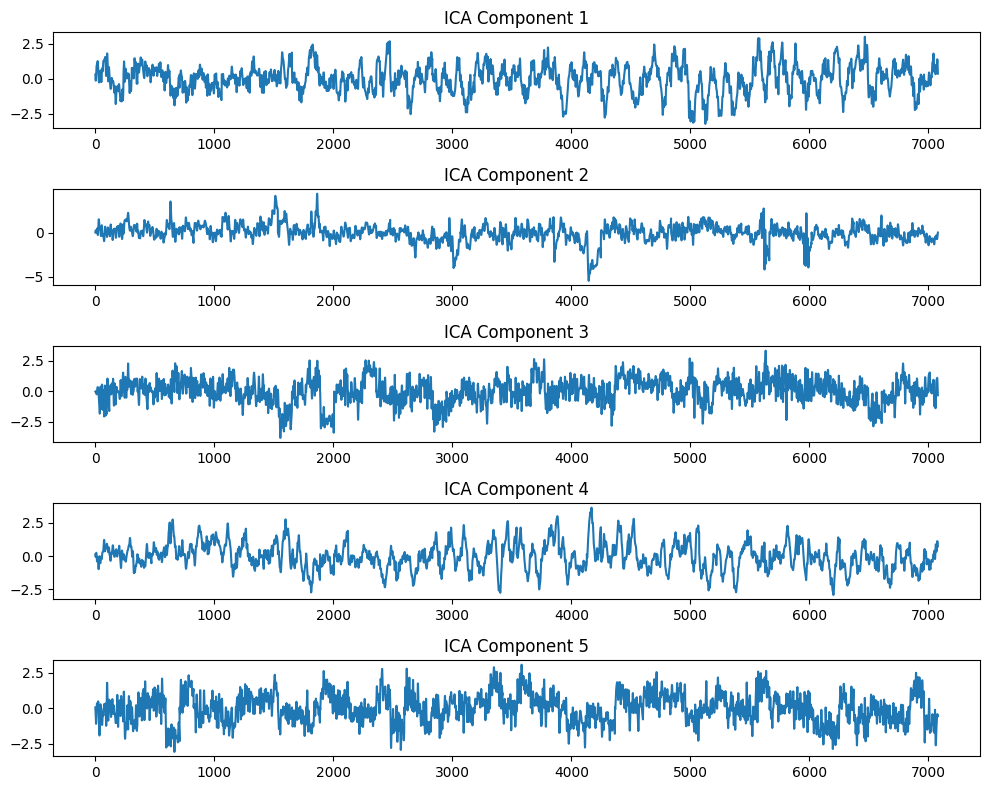

ΔBIC (1 vs 3 components) = -92.7  [BIC_1=1702,  BIC_3=1795]
χ² = 5.6  (dof=4),   p = 2.282e-01
Adjusted Rand Index = 0.001   (perm-test p = 3.651e-01)
Accuracy = 40.43%   (binomial p = 4.637e-02)


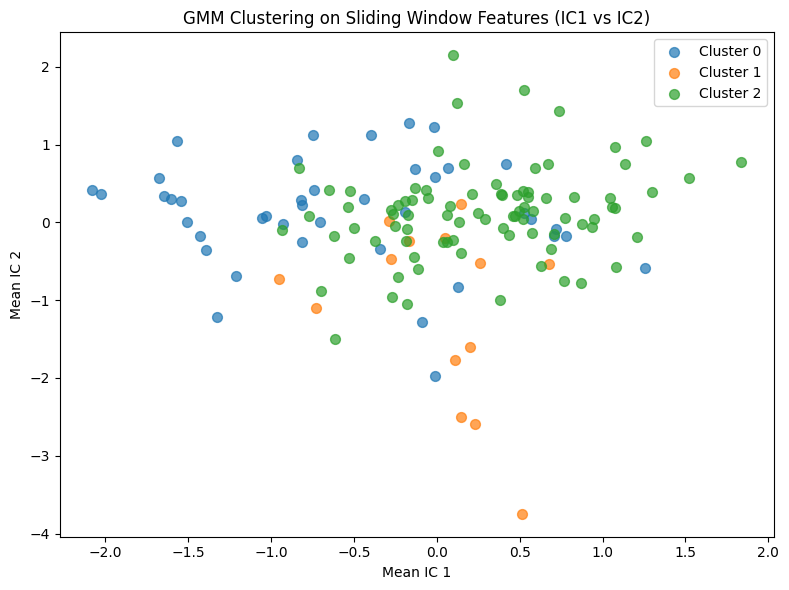

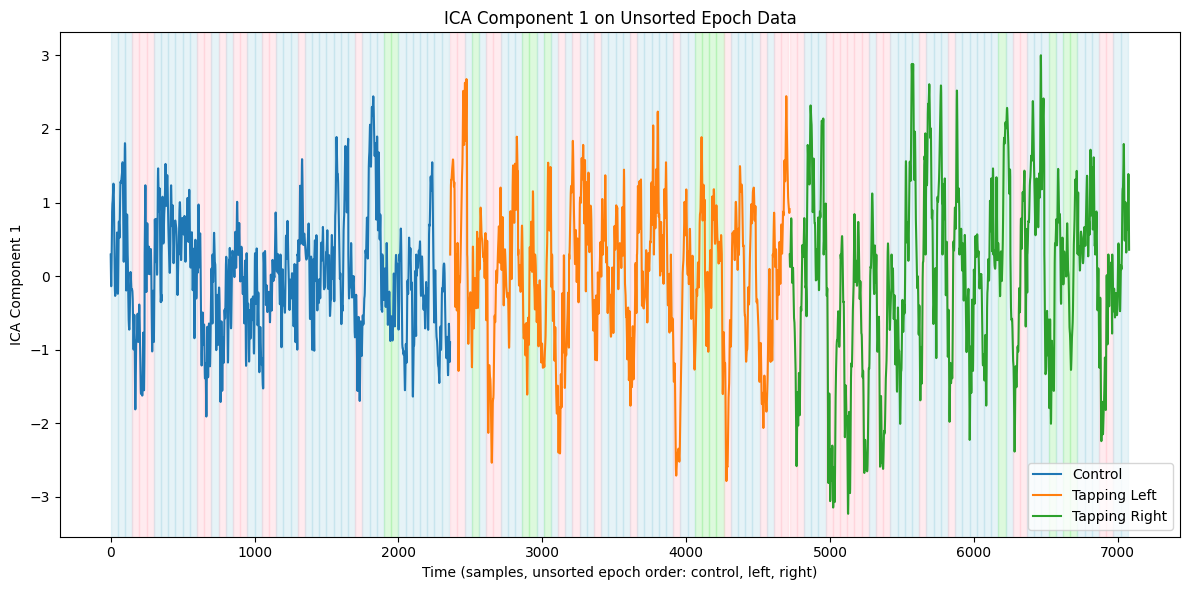

Contingency Table (Condition x Cluster):
Cluster     0   1   2
Condition            
Control    12   2  33
Tapping    29  12  53
Chi-square statistic = 3.573, Degrees of freedom = 2, p-value = 0.168
No statistically significant association was found between condition and cluster membership.


In [4]:
import pandas as pd
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from scipy.stats import chi2_contingency, binomtest

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

def load_full_data_all(subject=3, n_epochs=None):
    """
    Load and pool epochs from three conditions (Control, Tapping_Left, Tapping_Right).
    The data for each condition is reshaped by transposing each epoch (time as rows)
    and concatenated vertically. Also returns block boundaries and per-sample condition labels.
    """
    epochs = get_raw_subject_data(subject=subject, tmin=0, tmax=15)
    control = epochs['Control']
    left = epochs['Tapping_Left']
    right = epochs['Tapping_Right']
    
    # Use the minimum number of epochs across conditions if not specified.
    n_control = control.get_data().shape[0]
    n_left = left.get_data().shape[0]
    n_right = right.get_data().shape[0]
    if n_epochs is None:
        n_epochs = min(n_control, n_left, n_right)
    else:
        n_epochs = min(n_epochs, n_control, n_left, n_right)
    
    # Extract and reshape data by transposing each epoch.
    raw_control = control.get_data()[:n_epochs, :, :]
    raw_left = left.get_data()[:n_epochs, :, :]
    raw_right = right.get_data()[:n_epochs, :, :]
    n_epoch_size = raw_control.shape[2]
    
    def reshape_condition(raw_data):
        return raw_data.swapaxes(1,2).reshape(len(raw_data)*n_epoch_size, len(raw_data[0]))
    
    X_control = reshape_condition(raw_control)
    X_left = reshape_condition(raw_left)
    X_right = reshape_condition(raw_right)
    
    labels_control = np.full(X_control.shape[0], 1)
    labels_left = np.full(X_left.shape[0], 2)
    labels_right = np.full(X_right.shape[0], 3)
    
    X = np.concatenate([X_control, X_left, X_right], axis=0)
    cond_labels = np.concatenate([labels_control, labels_left, labels_right])
    
    # Boundaries for later back-projection.
    b0 = 0
    b1 = X_control.shape[0]
    b2 = b1 + X_left.shape[0]
    b3 = b2 + X_right.shape[0]
    boundaries = [b0, b1, b2, b3]
    return X, cond_labels, boundaries, n_epoch_size

def load_control_data_split(subject=3, n_epochs=None):
    """
    Load the control data only (using get_raw_control_subject_data), split the epochs into two halves,
    reshape each half separately, and assign labels 1 (first half) and 2 (second half).
    This simulates a case where no tapping is present.
    """
    control = get_raw_control_subject_data(subject=subject)
    all_data = control.get_data()
    if n_epochs is None:
        n_epochs = all_data.shape[0]
    else:
        n_epochs = min(n_epochs, all_data.shape[0])
    # Split epochs into two halves
    half = n_epochs // 2
    first_half = all_data[:half, :, :]
    second_half = all_data[half:n_epochs, :, :]
    n_epoch_size = first_half.shape[2]
    def reshape_epochs(raw_data):
        return np.concatenate([raw_data[i].T for i in range(raw_data.shape[0])], axis=0)
    X_first = reshape_epochs(first_half)
    X_second = reshape_epochs(second_half)
    labels_first = np.full(X_first.shape[0], 1)
    labels_second = np.full(X_second.shape[0], 2)
    X = np.concatenate([X_first, X_second], axis=0)
    labels = np.concatenate([labels_first, labels_second])
    boundaries = [0, X_first.shape[0], X_first.shape[0] + X_second.shape[0]]
    return X, labels, boundaries, n_epoch_size

def run_full_pool_ica_all(subject=3, n_epochs=None, n_components=5, standardized=True, use_control_loader=False):
    """
    Depending on the flag use_control_loader, either loads the full (3‐condition) data or only control data
    (split into two halves). Then standardizes the data (if requested) and runs ICA.
    """
    if use_control_loader:
        X, labels, boundaries, n_epoch_size = load_control_data_split(subject, n_epochs)
    else:
        X, labels, boundaries, n_epoch_size = load_full_data_all(subject, n_epochs)
    if standardized:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    ica = FastICA(n_components=n_components, max_iter=1000, tol=0.0001, random_state=42)
    X_ica = ica.fit_transform(X)
    return X_ica, ica, labels, boundaries, n_epoch_size

def compute_sliding_windows(X_ica, labels, window_size, step_size):
    """
    Compute sliding-window feature vectors by taking mean squared value (power) in each window.
    """
    features_list = []
    labels_list = []
    for cl in np.unique(labels):
        class_mask = (labels == cl)
        class_data = X_ica[class_mask, :]
        n_samples = class_data.shape[0]
        for start in range(0, n_samples - window_size + 1, step_size):
            window = class_data[start:start+window_size, :]
            avg_power = np.mean(window, axis=0)
            features_list.append(avg_power)
            labels_list.append(cl)
    return np.array(features_list), np.array(labels_list)

def run_gmm(features, n_components=3):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(features)
    cluster_labels = gmm.predict(features)
    return gmm, cluster_labels


# ------------------------------------------------------------------ #
#                           NEW STAT TESTS                           #
# ------------------------------------------------------------------ #
def gmm_bic_comparison(features, n_components=3):
    """
    Fit a 1-component and an n_components-component GMM,
    return BICs and ΔBIC = BIC(1) – BIC(n).
    Positive ΔBIC (>10 ≈ “very strong”) favours the larger model.
    """
    gmm_1 = GaussianMixture(n_components=1,  random_state=42).fit(features)
    gmm_k = GaussianMixture(n_components=n_components, random_state=42).fit(features)
    bic_1 = gmm_1.bic(features)
    bic_k = gmm_k.bic(features)
    return bic_1, bic_k, bic_1 - bic_k


def chi2_independence_test(true_labels, pred_labels):
    """
    χ² test of independence on the contingency table of true vs. predicted labels.
    Returns (chi2, dof, p_value).
    """
    ct = contingency_matrix(true_labels, pred_labels)
    chi2, p, dof, _ = chi2_contingency(ct, correction=False)
    return chi2, dof, p


def ari_permutation_test(true_labels, pred_labels, n_perm=10_000, random_state=42):
    """
    Compute observed Adjusted Rand Index and a permutation p-value.
    """
    rng = np.random.default_rng(random_state)
    obs_ari = adjusted_rand_score(true_labels, pred_labels)
    permuted = np.array([
        adjusted_rand_score(true_labels, rng.permutation(pred_labels))
        for _ in range(n_perm)
    ])
    p_val = (permuted >= obs_ari).mean()
    return obs_ari, p_val
# ------------------------------------------------------------------ #


def compute_accuracy(true_labels, pred_labels):
    """
    Maps predicted cluster labels to true labels using the Hungarian algorithm
    and returns the classification accuracy plus a binomial p-value.
    """
    cont_matrix = contingency_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cont_matrix)
    total_correct = cont_matrix[row_ind, col_ind].sum()
    accuracy = total_correct / np.sum(cont_matrix)

    # Binomial test against chance level (1 / #classes)
    n_classes = len(np.unique(true_labels))
    p_binom = binomtest(
        total_correct,
        n=np.sum(cont_matrix),
        p=1 / n_classes,
        alternative='greater'
    ).pvalue
    return accuracy, p_binom


def main():
    # Set this flag to True to use the control-only dataloader (simulate no tapping),
    # or False to use the real dataloader (with control and tapping conditions).
    use_control_dataloader = False  # Change to True to simulate no tapping

    # Parameters
    subject = 2
    n_epochs = 20          # epochs per group used in loading
    n_components = 5       # for ICA
    window_size = 50      # sliding window length in samples (adjust as needed)
    step_size   = 50       # sliding window step

    # Run ICA over pooled data (control-only or full real data, based on flag):
    X_ica, ica, labels, boundaries, n_epoch_size = run_full_pool_ica_all(
        subject, n_epochs, n_components, standardized=True,
        use_control_loader=use_control_dataloader)

    # Plot ICA components
    plot_ica_components(X_ica)

    # --- GMM CLASSIFIER PART ---
    # Compute sliding-window features:
    features, window_labels = compute_sliding_windows(
        X_ica, labels, window_size, step_size)

    # Fit Gaussian Mixture Model (3 comps):
    gmm, cluster_labels = run_gmm(features, n_components=3)

    # ------------------------------------------------------------------ #
    #                          STATISTICAL TESTS                         #
    # ------------------------------------------------------------------ #
    # 1. ΔBIC: does the data support 3 Gaussians?
    bic1, bic3, delta_bic = gmm_bic_comparison(features, n_components=3)
    print(f"ΔBIC (1 vs 3 components) = {delta_bic:.1f}  "
          f"[BIC_1={bic1:.0f},  BIC_3={bic3:.0f}]")

    # 2. χ² independence test:
    chi2, dof, p_chi2 = chi2_independence_test(window_labels, cluster_labels)
    print(f"χ² = {chi2:.1f}  (dof={dof}),   p = {p_chi2:.3e}")

    # 3. Adjusted Rand Index + permutation p-value:
    ari, p_perm = ari_permutation_test(window_labels, cluster_labels, n_perm=10_000)
    print(f"Adjusted Rand Index = {ari:.3f}   (perm-test p = {p_perm:.3e})")

    # 4. Accuracy + binomial test (only when true tapping labels exist):
    if not use_control_dataloader:
        acc, p_acc = compute_accuracy(window_labels, cluster_labels)
        print(f"Accuracy = {acc*100:.2f}%   (binomial p = {p_acc:.3e})")

        # Plot the GMM clusters of the sliding-window features:
        plot_gmm_clusters(features, cluster_labels)

        # For unsorted time-series plot, use the original X_ica order.
        block_colors   = {1: "C0", 2: "C1", 3: "C2"}
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        plot_unsorted_timeseries_with_clusters(
            X_ica, boundaries, block_colors,
            window_size, step_size,
            window_labels, cluster_labels,
            cluster_colors, ic=0, show_mean=False)
        

    if not use_control_dataloader:
        # For the real loader, collapse conditions into Control vs. Tapping (Tapping_Left/Right).
        group_labels = np.where(window_labels == 1, "Control", "Tapping")
    else:
        # For control dataloader, use the two set labels as they are.
        group_labels = np.where(window_labels == 1, "Set1", "Set2")
        
    df = pd.DataFrame({"Condition": group_labels, "Cluster": cluster_labels})
    contingency = pd.crosstab(df["Condition"], df["Cluster"])
    print("Contingency Table (Condition x Cluster):")
    print(contingency)
    
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)
    print(f"Chi-square statistic = {chi2_stat:.3f}, Degrees of freedom = {dof}, p-value = {p_val:.3f}")
    
    if p_val < 0.05:
        print("There is a statistically significant association between condition and cluster membership.")
    else:
        print("No statistically significant association was found between condition and cluster membership.")



if __name__ == "__main__":
    main()
